[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrvnthss/deep-learning-with-dobble/blob/main/interpretability-activations.ipynb)

# Interpretability Techniques: Intermediate Activations

**GitHub**: https://github.com/mrvnthss/deep-learning-with-dobble

**Purpose**: Part of a deep learning project based on the card game *Dobble*, implemented in PyTorch.

**Context**: Graded assignment as part of the *Deep Learning* Seminar at the [University of Giessen](https://www.uni-giessen.de)

**Author**: 2024 Marvin Theiss

**License**: [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.html)

Intermediate activations are a fundamental concept in deep learning interpretability. In the context of neural networks, especially deep convolutional neural networks (CNNs), **intermediate activations refer to the outputs of hidden layers during the forward pass of the network** when an input is propagated through it.

When we feed an input (e.g., an image of our *Dobble* cards) to a deep neural network, it undergoes a series of transformations as it passes through the various layers of the network. Each layer applies a set of filters or weights to the input and then passes the transformed data to the next layer. At each layer, the output is called the intermediate activation. The importance of intermediate activations for interpretability lies in the fact that they provide insights into what the network is learning at different stages. By visualizing these activations, we can gain a better understanding of what features the network is extracting from the input data. 

In neuroscience, researchers often use single-unit recordings to study how individual neurons in the brain respond to different stimuli. In macaque monkeys, for example, researchers might present visual stimuli, such as images, to the monkeys while recording the activity of single neurons in the visual cortex.

<div style="text-align: center">
    <figure>
        <img src="https://cdn.the-scientist.com/assets/articleNo/69201/iImg/43586/a-favorite-number-infographic-2.jpg" width="700">
        <br>
        <figcaption style="text-align: center">
            <a href="https://www.murphyscienceart.com">&copy; MURPHYSCIENCEART.COM</a>
        </figcaption>
    </figure>
</div>

The parallel to intermediate activations in deep learning becomes evident when we consider that both techniques aim to understand how information is processed at different stages. In single-unit recordings, each recorded neuron represents a single unit of information processing. By studying the activity of these individual neurons, researchers can infer the types of stimuli or features that trigger responses in those neurons. In deep learning, intermediate activations can be seen as analogous to the activity of single neurons (or groups of neurons) in the brain. Each intermediate activation corresponds to a set of neurons in a particular layer of the neural network. By visualizing and analyzing these activations, we can gain **insights into what features or patterns the network is responding to at different layers**.

Both techniques, single-unit recordings in macaque and intermediate activations in deep learning, provide valuable information about the hierarchical processing of information. In macaque, researchers study how individual neurons respond to stimuli and build a picture of how visual information is processed at different levels of the visual cortex. In deep learning, we study intermediate activations to understand how features are hierarchically extracted and combined to make decisions about the input data.


## Preparation

### Importing Packages

As in the main notebook, we import all the packages that we'll be using up-front. We follow the recommended order of ordering imports in Python, i.e.,
1. standard library imports
2. third-party library imports
3. local imports (not applicable here)

In [1]:
import colorsys
from pathlib import Path
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms

### Setting Constants

Similarly, we set up the constant variables that we'll use throughout this notebook.

In [2]:
DEVICE = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
    )

# Directories
IMAGES_DIR = Path('data/processed/classic-dobble')
RESNET_DIR = Path('models/resnet18')

# Preprocessing values
MEAN = [0.6433, 0.635, 0.6188]
STD = [0.2535, 0.2543, 0.2659]

# For reproducibility purposes
RANDOM_SEED = 15

### Load ResNet-18 With Pre-Trained Weights

Next, we need to create an instance of **ResNet-18** and load the weights that we obtained from training it on our custom Dobble dataset.

In [3]:
NUM_CLASSES = 57
url = 'https://dl.dropboxusercontent.com/scl/fi/vfqz1yz0jh27h6w0soxh3/best_performing.tar.gz?rlkey=90qvovqoc9zgvt5ceoz6adi0n'
datasets.utils.download_and_extract_archive(url, download_root=RESNET_DIR, filename='best_performing.tar.gz', remove_finished=True)
CHECKPOINT = torch.load(RESNET_DIR / 'best_performing.pt', map_location=DEVICE)

# Create ResNet-18 model
RESNET_18 = models.resnet18()

# Replace fully connected layer
in_features = RESNET_18.fc.in_features
RESNET_18.fc = nn.Linear(in_features=in_features, out_features=NUM_CLASSES)

# Load pre-trained weights, move to GPU (if available), and set to evaluation mode
RESNET_18.load_state_dict(CHECKPOINT['model_state_dict'])
RESNET_18.to(DEVICE)
_ = RESNET_18.eval()

100.0%


Extracting models/resnet18/best_performing.tar.gz to models/resnet18


### Functions From Main Notebook

Finally, we also need to copy & paste some of the functions that we have written in our main notebook.

In [4]:
def compute_quadrant_coordinates(
        quadrant: int,
        image_size: int) -> tuple[int, int]:
    """Compute the coordinates of a specified quadrant within a square image.

    Args:
        quadrant (int): The quadrant number, ranging from 1 to 4.
        image_size (int): The size of the square image.

    Returns:
        tuple[int, int]: The upper left coordinates (x, y) of the specified quadrant within the square image.

    Raises:
        ValueError: If an invalid 'quadrant' (number) is provided.
    """
    quadrant_size = image_size // 2
    
    if quadrant == 1:  # upper right
        coordinates = (quadrant_size, 0)
    elif quadrant == 2:  # upper left
        coordinates = (0, 0)
    elif quadrant == 3:  # lower left
        coordinates = (0, quadrant_size)
    elif quadrant == 4:  # lower right
        coordinates = (quadrant_size, quadrant_size)
    else:
        raise ValueError('Invalid quadrant. Please provide a value from 1 to 4.')

    return coordinates


def create_tile_image(
        image1: Image.Image,
        image2: Image.Image,
        quadrants: tuple[int, int],
        bg_color: tuple[int, int, int] = None,
        return_pil: bool = True) -> Image.Image | np.ndarray:
    """Create a tile image by combining two square images based on the specified quadrants.

    Args:
        image1 (Image.Image): The first input image to place on the tile image.
        image2 (Image.Image): The second input image to place on the tile image.
        quadrants (tuple[int, int]): Tuple of integers from 1 to 4 representing the quadrants in which
            the two images will be placed.
        bg_color (tuple[int, int, int]): The RGB color tuple for the background color.  Defaults to None.
        return_pil (bool): Whether to return a PIL Image ('True') or a NumPy array ('False').  Defaults to True.

    Returns:
        Image.Image or np.ndarray: The generated tile image.

    Raises:
        ValueError: If two identical quadrants are provided.
    """
    if quadrants[0] == quadrants[1]:
        raise ValueError('Two identical quadrants provided. Images would overlap.')

    tile_image_size = 2 * image1.width

    # Choose random background color if 'bg_color' was not specified
    if bg_color is None:
        bg_color = tuple(np.random.randint(0, 256, size=3, dtype=np.uint8))

    tile_image = Image.new('RGBA', (tile_image_size, tile_image_size), bg_color)

    image1_pos = compute_quadrant_coordinates(quadrants[0], tile_image_size)
    image2_pos = compute_quadrant_coordinates(quadrants[1], tile_image_size)

    tile_image.paste(image1, image1_pos, mask=image1)
    tile_image.paste(image2, image2_pos, mask=image2)

    return tile_image if return_pil else np.array(tile_image)


## Intermediate Activations

As explained at the very beginning of this notebook, we want to understand what features or patterns the network is responding to at different layers. To do so, we will first **re-create images that are similar to those that we've used to train the network** (here: ResNet-18). Additionally, we will create images of single playing cards that we'll pass through the network. After we have created these images, we need to **attach forward hooks** to the layers from which we want to measure intermediate activations. Once everything is set up, we can pass images through the network and **measure the intermediate activations** and then **analyze them qualitatively and quantitatively**.


### Re-Creating Images of Dobble Playing Cards

Here, we re-create images similar to those we used to train ResNet-18 in our main notebook. First, we **set a random seed for reproducibility purposes**.

In [5]:
# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Next, we randomly select 6 images of *Dobble* playing cards from our classic *Dobble* deck. We'll pass two of these through the model as single playing cards, and the remaining four will be arranged into two images of two playing cards each.

In [6]:
# Download images
url = 'https://dl.dropboxusercontent.com/scl/fi/nqsrgrxo3klpk985xqtek/classic-dobble.tar.gz?rlkey=veb2q75rcvlgch9wbf6i416gl'
datasets.utils.download_and_extract_archive(url, download_root=IMAGES_DIR, filename='classic-dobble.tar.gz', remove_finished=True)

# Randomly select 6 images of playing cards
num_cards = 6
image_ids = random.sample(range(1, NUM_CLASSES + 1), num_cards)
file_paths = [IMAGES_DIR / f'classic-dobble_{id:03d}.png' for id in image_ids]

# Load images
images = [Image.open(file_path) for file_path in file_paths]

# Arrange four playing cards into two images of two playing cards each
quadrants = [(1, 3), (3, 4)]
pairs_of_cards = [
    create_tile_image(images[2], images[3], quadrants[0]),
    create_tile_image(images[4], images[5], quadrants[1])
    ]

# Collect all four images into single list and convert to RGB (i.e., drop alpha channel)
input_images = []
for count in range(2):
    input_images.append(images[count].convert('RGB'))
    input_images.append(pairs_of_cards[count].convert('RGB'))
input_images[1], input_images[2] = input_images[2], input_images[1]

100.0%


Extracting data/processed/classic-dobble/classic-dobble.tar.gz to data/processed/classic-dobble


Finally, let's visualize these images.

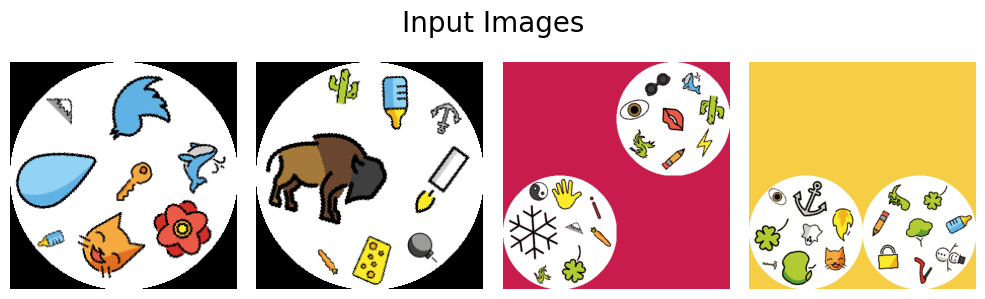

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
axes = axes.flatten()

for count, image in enumerate(input_images):
    ax = axes[count]
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Input Images', size=20)
plt.tight_layout()
plt.show()

Next, we need to convert this list of PIL images into a single `torch.Tensor`.

In [8]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=MEAN, std=STD)
    ])

torch_images = torch.stack([preprocess(image) for image in input_images])

# Get the shape of the input tensor
shape_str = 'Shape of input tensor\n\nbatch size: {}\nchannels: {}\nheight: {}\nwidth: {}\n'.format(
    torch_images.size(0),  # batch size
    torch_images.size(1),  # channels
    torch_images.size(2),  # height
    torch_images.size(3)   # width
    )
print(shape_str)

Shape of input tensor

batch size: 4
channels: 3
height: 224
width: 224



Let's plot the resized and preprocessed images once more.

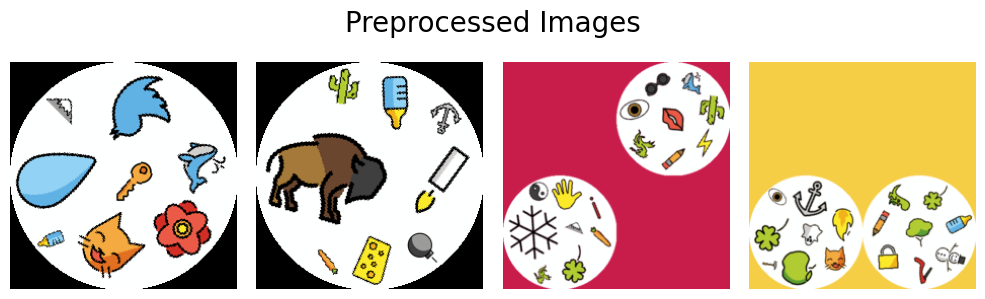

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
axes = axes.flatten()

for count, image in enumerate(torch_images):
    ax = axes[count]
    image = image.numpy().transpose(1, 2, 0) * STD + MEAN
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Preprocessed Images', size=20)
plt.tight_layout()
plt.show()

Not surprisingly (we preprocessed the images and then undid the preprocessing to visualize the images), we don't see much of a difference. The only noticeable difference is that the tile images of two playing cards each are slightly blurred due to the resizing.


### Attach Forward Hooks

Now that we have the images we want to pass through our network, we need to attach forward hooks to measure the intermediate activations. Let's first **print the names of all the top-tier layers** of ResNet-18.

In [10]:
top_tier_layers = [key for key, _ in RESNET_18.named_children()]
print(top_tier_layers)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


Next, we initialize a **dictionary** that we'll use **to store the intermediate activations** every time an image is passed through the network.

In [11]:
activations = dict()

We proceed by defining functions that let us ...
- collect the intermediate activation of a specified layer,
- register forward hooks on multiple layers of a network.

In [12]:
def get_activation(layer):
    """Store the activation of a specified layer in the activations dictionary."""
    def hook(model, input, output):
        activations[layer] = output.detach().cpu()
    return hook


def attach_hooks(model, layer_names):
    """Attach a hook to all specified layers of the model."""
    hooks = dict()
    for layer_name in layer_names:
        # Attach hook and store reference to hook in dictionary
        layer = getattr(model, layer_name)
        hooks[layer_name] = layer.register_forward_hook(get_activation(layer_name))
    return hooks


Let's attach hooks to some of the layers of our trained ResNet-18 model.

In [13]:
resnet18_hooks = attach_hooks(RESNET_18, ['conv1', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4'])

### Qualitative Analysis

With our hooks attached, we can move on and start measuring the intermediate activations of our network. The first thing we need to do is straightforward: We pass our batch of four images to the model and, by doing so, collect the activations in our `activations` dictionary.

In [14]:
with torch.no_grad():
    _ = RESNET_18(torch_images.to(DEVICE))

To understand what's going on, let's print the shapes of the tensors storing the activations.

In [15]:
for layer_name, layer_activations in activations.items():
    print(f'{layer_name}: {tuple(layer_activations.shape)}')

conv1: (4, 64, 112, 112)
maxpool: (4, 64, 56, 56)
layer1: (4, 64, 56, 56)
layer2: (4, 128, 28, 28)
layer3: (4, 256, 14, 14)
layer4: (4, 512, 7, 7)


We immediately see that the first dimension corresponds to the four images that we passed to the network. The second dimension corresponds to the number of units, which we have collected activations from after each layer. The last two dimensions correspond to the spatial resolution of the images that we passed to the network.

Given that information, let's **look at the activations of the first 32 kernels of each layer produced by the first image**.

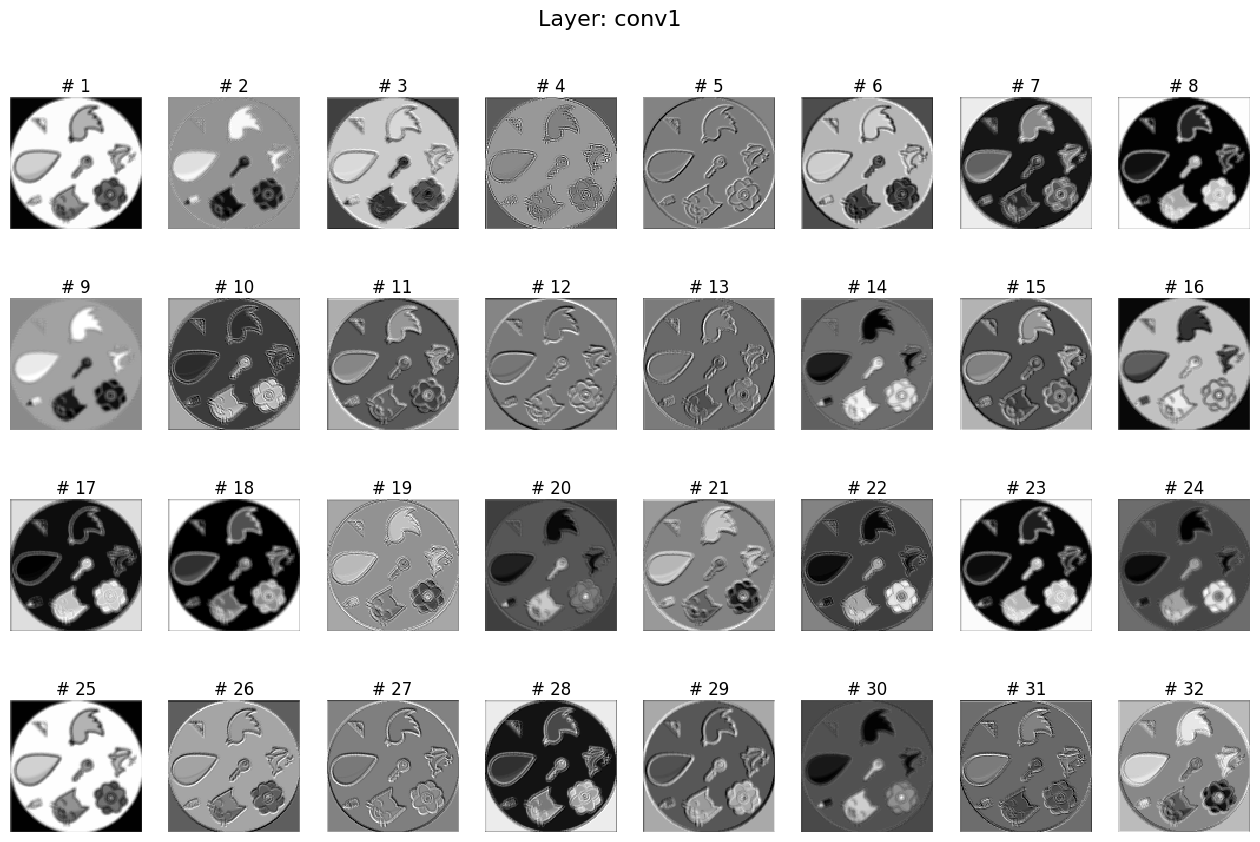

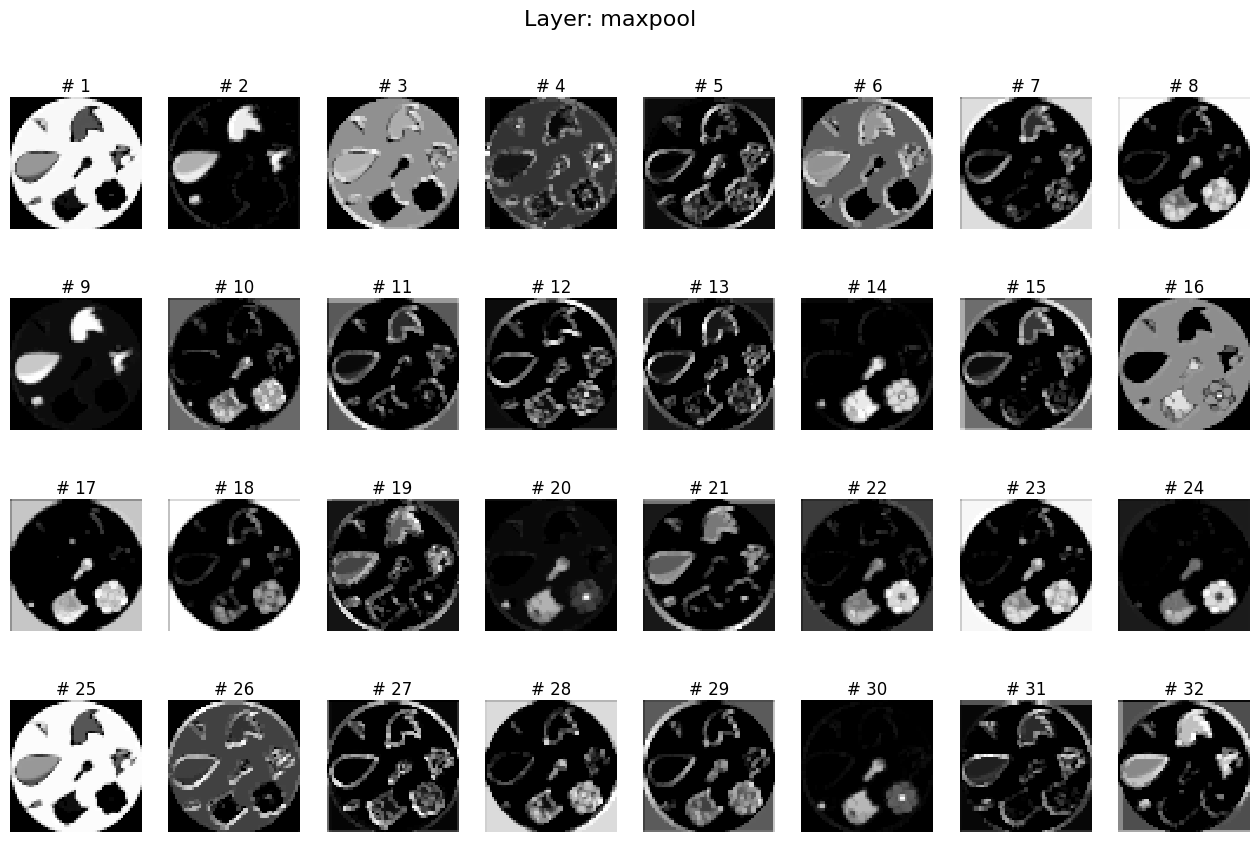

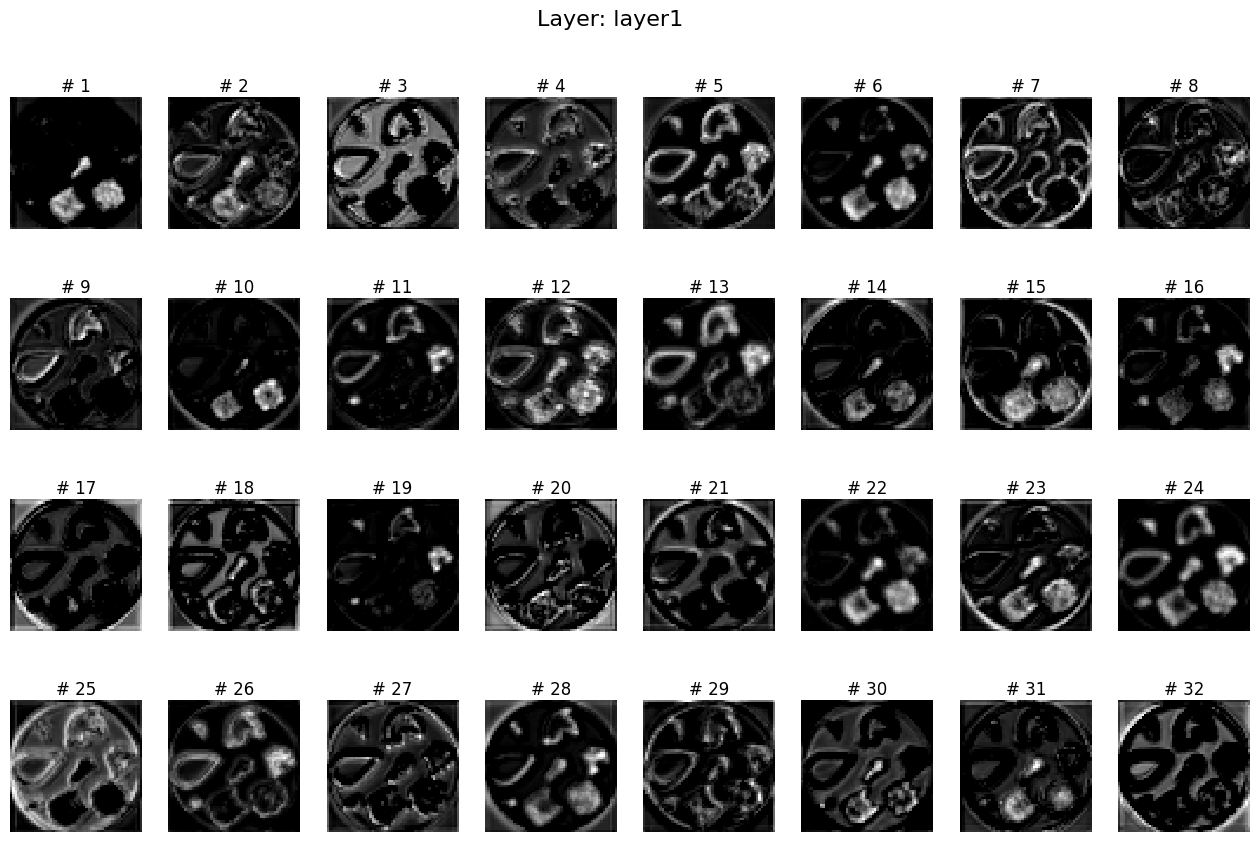

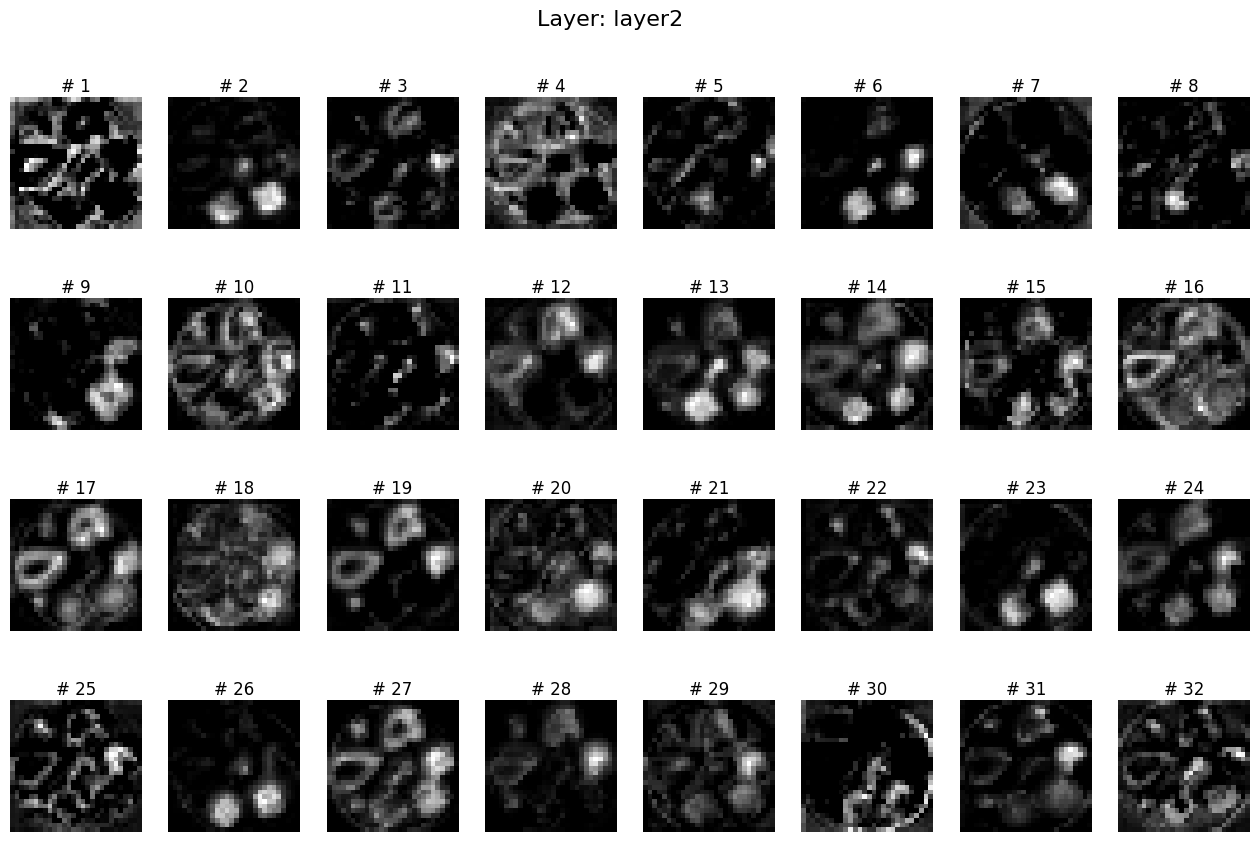

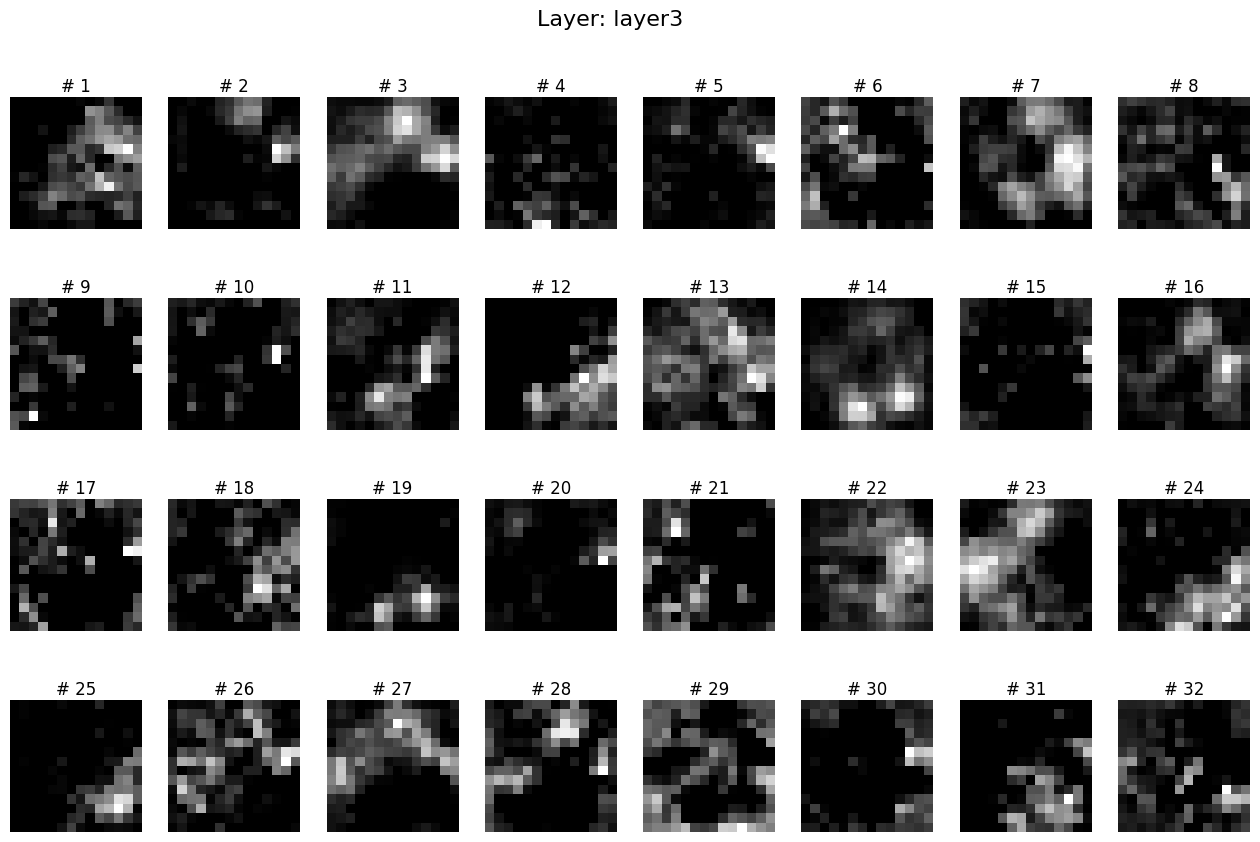

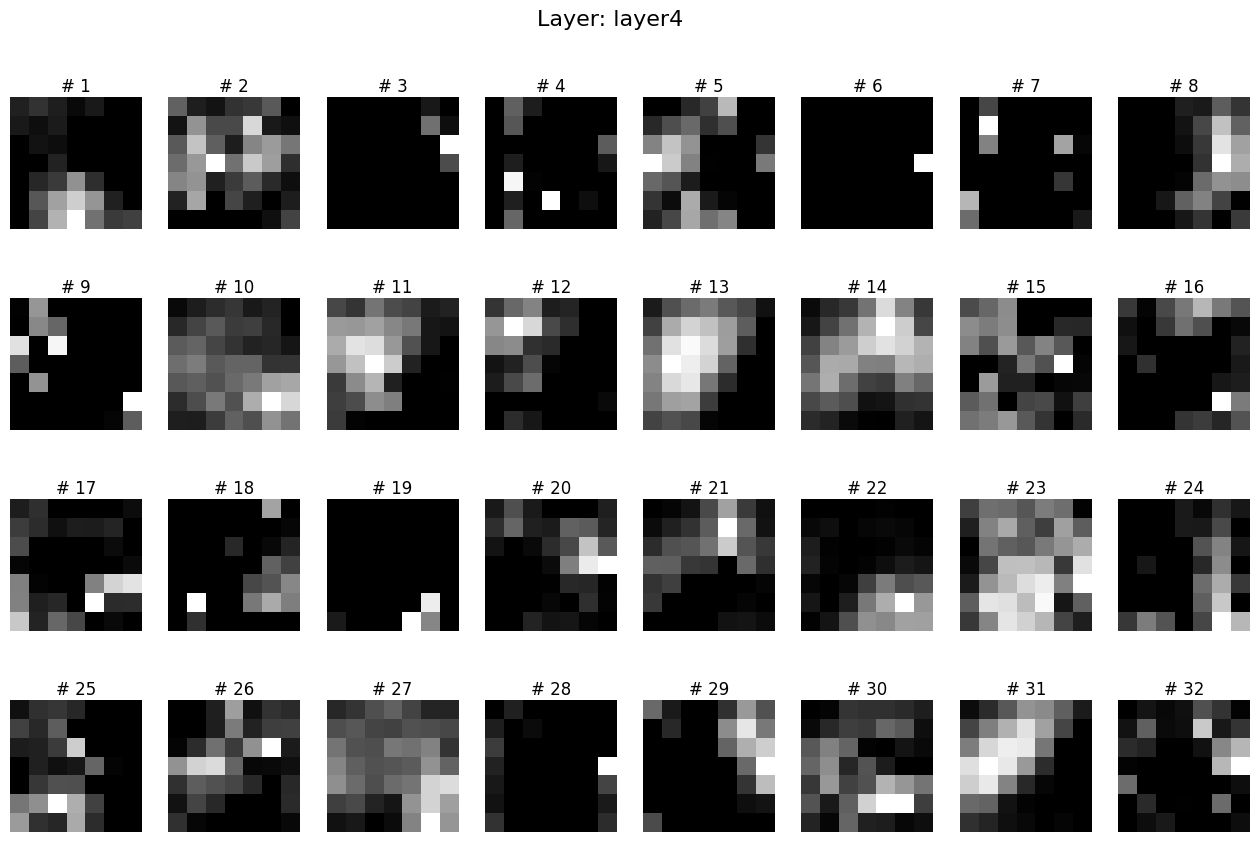

In [16]:
# Get the activations produced by the first image in the batch
first_image_activations = {layer: activations[layer][0] for layer in activations}

# Plot activations for the first 32 kernels of each layer
for count, (layer_name, layer_activations) in enumerate(first_image_activations.items()):
    num_kernels = min(32, layer_activations.shape[0])

    if count > 0:
        print('\n\n\n')
    
    fig, axes = plt.subplots(4, 8, figsize=(16, 10))
    fig.suptitle(f'Layer: {layer_name}', fontsize=16, y=0.95)
    for i, ax in enumerate(axes.flatten()):
        ax.matshow(layer_activations[i], cmap='gray')
        ax.set_title(f'# {i+1}', y=0.98)
        ax.axis('off')
    plt.show()

Immediately, there are several things we notice:

- We tend to recognize the original image less the further down we look at the activations. This is expected, especially since the spatial resolution decreases monotonically with network depth.
- The kernels of the first layer (`maxpool`, **not** `layer1`) seem to pick up on particular features:
    * Some kernels respond strongly to the **outlines** of the emojis, such as kernel # 27
    * Some kernels respond particularly strongly to a certain **color**. A prime example of this is kernel # 9. That kernel seems to respond almost exclusively to **blueish colors** with a preference for darker blues (look at the droplet of water!) and nothing else.
- Quite a few kernels of the first layer (again, `maxpool`, **not** `layer1`) still respond quite strongly to the playing cards themselves (i.e., the white disk). However, this information is not too useful for solving the task at hand. Interestingly, we see that this information (playing card background) seems to be slowly discarded as we move further down the network.

**Note**: We only plotted a small selection of all the kernels and only looked at the intermediate activations to a single image. Yet, we could still spend an awful amount of additional time trying to *qualitatively* analyze these activations. Instead let's move on and try to do some *quantitative* analysis to finish up.


### Quantitative Analysis

Let's try to run some quantitative analysis. For the sake of this notebook, let's try to see if we can manage to **find out whether or not layers at different depths respond more strongly to certain colors than others**. To do this, we will proceed as follows:

- Create stimuli consisting of uniformly colored patches. We vary these colors by continuously varying the hue across the hue circle.
- We pass this batch of stimuli to the network and measure the intermediate activations. For each kernel at each layer, we compute the mean activation across the spatial resolution.
- For each layer and each color, we count the number of kernels that respond strongest to that particular color.
- For each layer, we create a histogram visualizing this color preference. *Perhaps this preference shifts as we move down the network?*

Let's first implement a simple function that creates uniformly colored patches.

In [17]:
def make_colored_patches(
        image_size: int,
        hues: list[float]) -> list[np.ndarray]:
    """Generate a list of colored patches based on given hues.

    Args:
        image_size (int): The size of each square patch.
        hues (list[float]): List of hue values (in range 0 to 1) to create colored patches.

    Returns:
        list[np.ndarray]: A list of colored square patches as NumPy arrays.
    """
    images = []
    for hue in hues:
        color = np.array(colorsys.hsv_to_rgb(hue, 1, 1)) * 255
        img = np.full((image_size, image_size, 3), color, dtype=np.uint8)
        images.append(img)
    return images


Next, we create 8 colored patches by varying the hue accordingly.

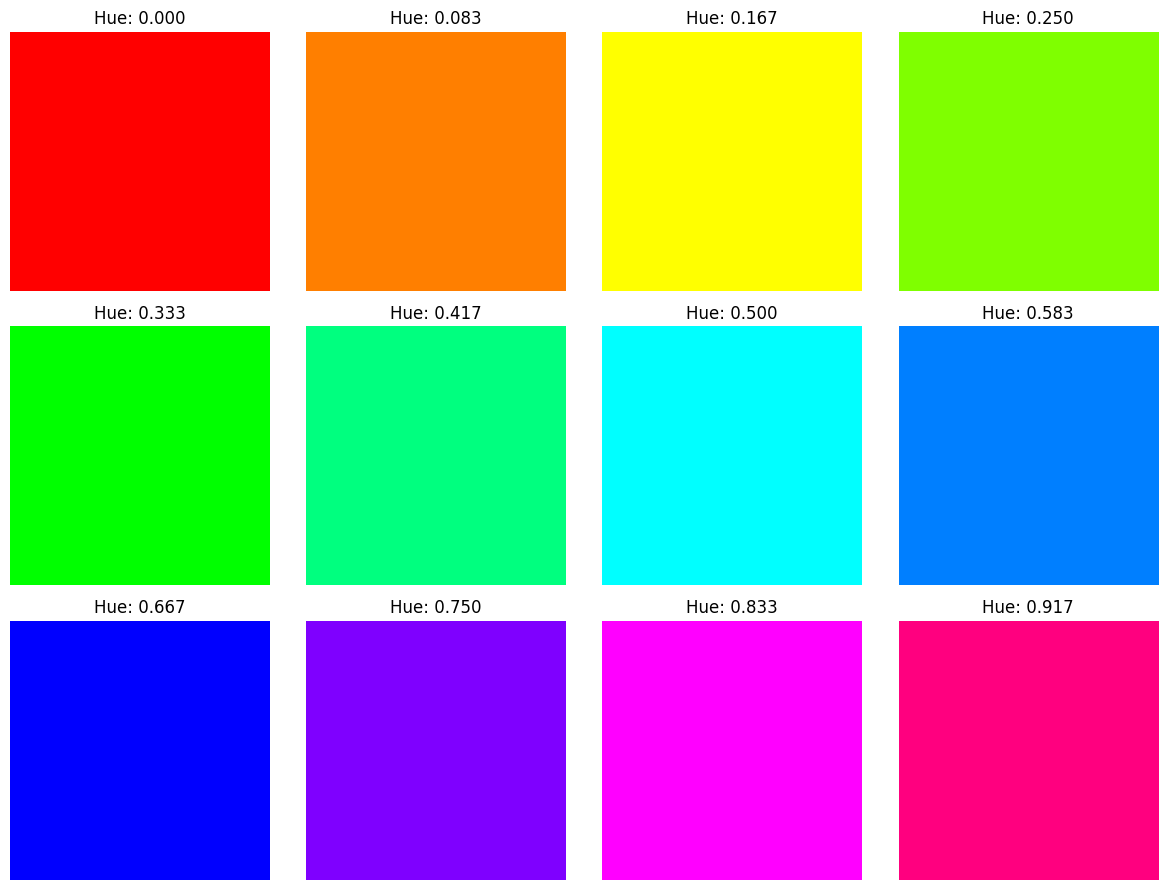

In [18]:
num_hues = 12
# NOTE: We set endpoint=False because hue is a circular measure
hue_np = np.linspace(0, 1, num_hues, endpoint=False)
hue_images = make_colored_patches(224, hue_np)

# Visualize the different hues in a 3x4 subplot
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i, image in enumerate(hue_images):
    axes[i].imshow(image)
    axes[i].set_title(f'Hue: {hue_np[i % num_hues]:.3f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Let's combine these images into a single `torch.Tensor` that we can pass to our model.

In [19]:
torch_hues = torch.stack([preprocess(hue) for hue in hue_images])

# Get the shape of the input tensor
shape_str = 'Shape of input tensor\n\nbatch size: {}\nchannels: {}\nheight: {}\nwidth: {}\n'.format(
    torch_hues.size(0),  # batch size
    torch_hues.size(1),  # channels
    torch_hues.size(2),  # height
    torch_hues.size(3)   # width
    )
print(shape_str)

Shape of input tensor

batch size: 12
channels: 3
height: 224
width: 224



Next, let's pass this batch of images to our model and **measure the activations**.

In [20]:
with torch.no_grad():
    _ = RESNET_18(torch_hues.to(DEVICE))

As before, let's print the shapes of the tensors storing the activations.

In [21]:
for layer_name, layer_activations in activations.items():
    print(f'{layer_name}: {tuple(layer_activations.shape)}')

conv1: (12, 64, 112, 112)
maxpool: (12, 64, 56, 56)
layer1: (12, 64, 56, 56)
layer2: (12, 128, 28, 28)
layer3: (12, 256, 14, 14)
layer4: (12, 512, 7, 7)


We need to compute the **mean activation** for each kernel of each layer **across the entire spatial resolution**.

In [22]:
# Create a new dictionary to store the mean activations for each layer
mean_activations = dict()

# Calculate the mean activation for each kernel in each layer across the spatial resolution
for layer_name, layer_activations in activations.items():
    mean_activations[layer_name] = layer_activations.mean(dim=(2, 3))

Let's print the shape of the tensors again to make sure that we did everything correctly.

In [23]:
for layer_name, layer_activations in mean_activations.items():
    print(f'{layer_name}: {tuple(layer_activations.shape)}')

conv1: (12, 64)
maxpool: (12, 64)
layer1: (12, 64)
layer2: (12, 128)
layer3: (12, 256)
layer4: (12, 512)


That looks good! Now we need to figure out **what hue each kernel (of each layer) responded to most strongly**.

In [24]:
# Create a dictionary to store the counts of kernels responding most strongly to each image in each layer
strongest_responses = dict()

# Loop over each layer and find the image index with the maximum response for each kernel
for layer_name, layer_activations in mean_activations.items():
    # Find the image index with the maximum response for each kernel
    strongest_responses_indices = torch.argmax(layer_activations, dim=0)
    
    # Count the occurrences of each image index and store in the dictionary
    counts = torch.bincount(strongest_responses_indices, minlength=num_hues)
    strongest_responses[layer_name] = counts

Finally, let's **visualize the distribution of strongest responses** per layer.

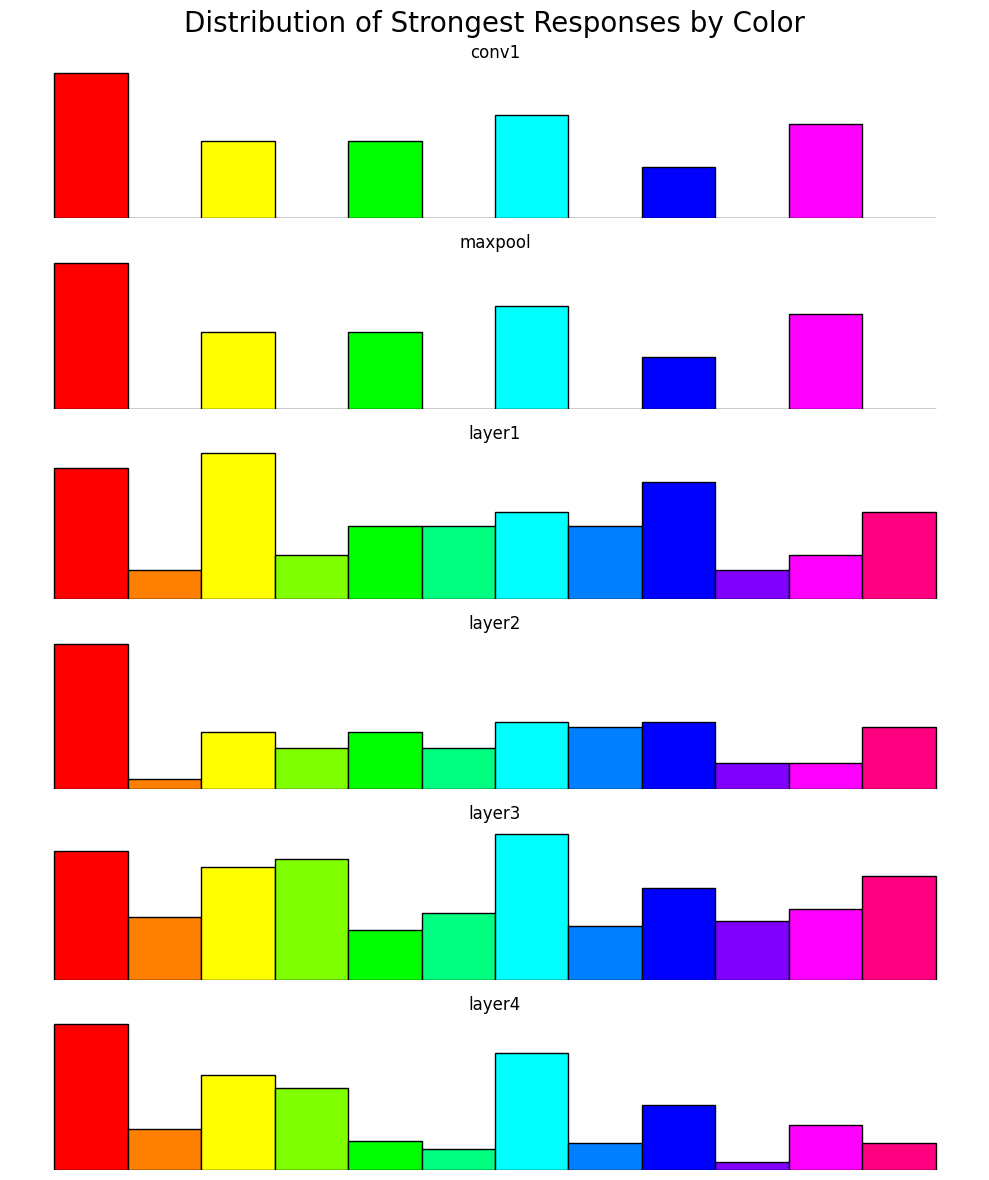

In [25]:
bin_colors = []
for hue in hue_np:
    color = colorsys.hsv_to_rgb(hue, 1, 1)
    bin_colors.append(color)
    
# Plot normalized histograms for each layer
fig, axes = plt.subplots(len(strongest_responses), figsize=(10, 12), sharex=True)

for idx, (layer_name, counts) in enumerate(strongest_responses.items()):
    _, _, patches = axes[idx].hist(
        range(num_hues), bins=num_hues, weights=counts, density=True, edgecolor='black', linewidth=1
        )
    for count, patch in enumerate(patches):
        patch.set_facecolor(bin_colors[count])
    axes[idx].set_title(layer_name)
    axes[idx].set_xlabel('Hue')
    axes[idx].set_xticks(range(num_hues))
    axes[idx].axis('off')

plt.suptitle('Distribution of Strongest Responses by Color', size=20)
plt.tight_layout()
plt.show()